## DFBA of *S. cerevisiae* 

Based on this example: 
https://gitlab.com/davidtourigny/dynamic-fba/-/blob/main/examples/example3.py

from:
https://dynamic-fba.readthedocs.io/en/latest/examples.html

REMEMBER to run in the dfba env


CHECK THIS OUT: https://cobrapy.readthedocs.io/en/0.19.0/dfba.html



In [1]:
# Copyright (C) 2018, 2019 Columbia University Irving Medical Center,
#     New York, USA
# Copyright (C) 2019 Novo Nordisk Foundation Center for Biosustainability,
#     Technical University of Denmark

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.

"""Aerobic growth of *S. cerevisiae* on glucose.

Switch to anaerobic conditions at *t=7.7h*
Organism -> Saccharomyces cerevisiae S288C
Model stored in http://bigg.ucsd.edu/models/iND750
"""

from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import ControlParameter, DfbaModel, ExchangeFlux, KineticVariable


In [2]:
from dfba.plot.matplotlib import *

In [3]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra import Model, Reaction, Metabolite

In [4]:
# DfbaModel instance initialized with cobra model
# fba_model = read_sbml_model(
#     join(dirname(__file__), pardir, "sbml-models", "iND750.xml.gz")
# )

fba_model = read_sbml_model('../../models/iMM904_progesterone_fixed.xml')

In [5]:
#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')
fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_c'), type='demand')

fba_model.objective = fba_model.reactions.R02216
fba_model.optimize().objective_value

0.14285714285714288

In [6]:
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [7]:
fba_model

Name,iMM904
Memory address,0x07fe7b7d68a90
Number of metabolites,1235
Number of reactions,1588
Number of groups,0
Objective expression,1.0*R02216 - 1.0*R02216_reverse_2ed70
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [8]:
# instances of KineticVariable
V = KineticVariable("Volume")
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Eth = KineticVariable("Ethanol")
Pro = KineticVariable("Progesterone")
# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([V, X, Gluc, Eth, Pro])


In [9]:
# instances of ExchangeFlux
mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_E = ExchangeFlux("EX_etoh_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_E, v_O, v_P])

In [21]:
v_P

v1

In [10]:
# add rhs expressions for kinetic variables in dfba_model
Vgmax = 8.5
Kg = 0.5
D = 0.044
Gin = 100.0
Vomax = 8.0
Oxy = ControlParameter("Oxygen", [7.7], [Vomax, 0.0])


dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Biomass", mu * X - D * X / V)
dfba_model.add_rhs_expression("Glucose", v_G * X + D * (Gin - Gluc) / V)
dfba_model.add_rhs_expression("Ethanol", v_E * X - D * Eth / V)
dfba_model.add_rhs_expression("Progesterone", v_P * X - D * Pro / V)

In [11]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
dfba_model.add_exchange_flux_lb("EX_o2_e", Oxy, control_parameters=Oxy)

In [17]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)

#old conditions: 

dfba_model.add_initial_conditions(
    {
        "Volume": 0.5,
        "Biomass": 0.05,
        "Glucose": 10.0,
        "Ethanol": 0.0,
        "Glycerol": 0.0,
    }
)

# dfba_model.add_initial_conditions(
#     {
#         "Biomass": 0.05,
#         "Glucose": 10.0,
#         "Ethanol": 0.0,
#         "Progesterone": 0.0
#     }
# )

#Oxygen since it does notcorrespond to a kinetic variable in the model.


Ignoring initial condition for Glycerol since it does notcorrespond to a kinetic variable in the model.


In [18]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 16.0, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_etoh_e", "EX_o2_e", "DM_progesterone_c"])


# [IDA ERROR]  IDACalcIC
#   The linesearch algorithm failed: step too small or too many backtracks.


# SUNDIALS_ERROR: IDACalcIC() failed with flag = -13

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 17
Number of nonlinear iterations     = 0
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 0

Total simulation time was 2.07812 seconds



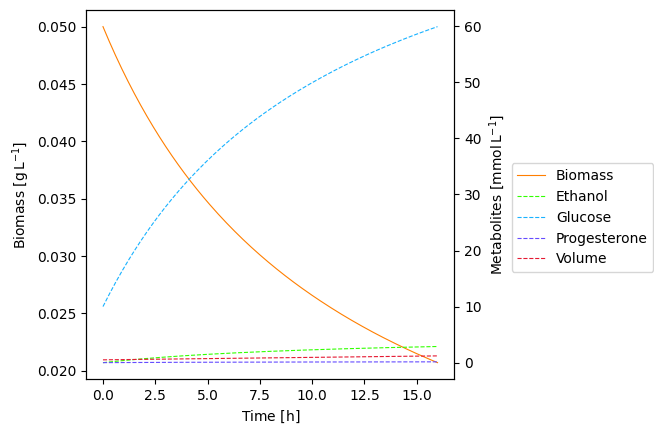

In [19]:
plot_concentrations(concentrations)

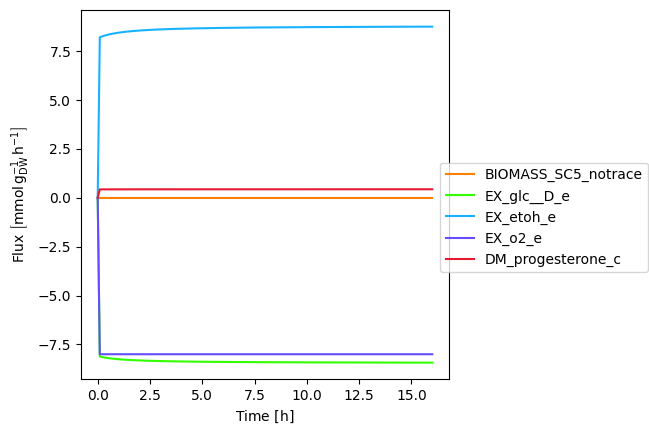

In [20]:
plot_trajectories(trajectories)